In [8]:
import zipfile
import pandas as pd
import re
import nltk
nltk.download('punkt')
import demoji
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud

nltk.download('punkt_tab') #tokenizzazione
nltk.download('stopwords') # stop words
nltk.download('wordnet') # lemmatizzazione
demoji.download_codes() # dizionario delle emoji

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alep9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alep9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alep9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alep9\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\alep9\AppData\Local\Temp\ipykernel_29720\2357680478.py:17: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes() # dizionario delle emoji


In [17]:
zip_path = 'redditComments.zip'

with zipfile.ZipFile(zip_path) as z:
    with z.open('ruddit_comments_score.csv') as csv:
        df = pd.read_csv(csv)

print("Dataset shape:", df.shape)

Dataset shape: (5966, 3)


In [18]:
df = df.drop(columns='comment_id')
print(df.columns)

Index(['body', 'score'], dtype='object')


In [19]:
#Rimozione dei commenti nulli
df = df.dropna(subset=['body'])
df.drop(df[df['body'].str.startswith('[')].index, inplace=True)


In [20]:
dict1 = {
    "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "won't": "will not", "can't": "cannot", "i'm": "i am", "you're": "you are",
    "it's": "it is", "they're": "they are", "we're": "we are", "isn't": "is not",
    "aren't": "are not", "haven't": "have not", "hasn't": "has not",
    "wasn't": "was not", "weren't": "were not", "shouldn't": "should not",
    "wouldn't": "would not", "couldn't": "could not", "mustn't": "must not"
}

dict2 = {
    "nude": "naked", "xxx": "porn", "tits": "breasts", "dick": "penis",
    "pussy": "vagina", "bj": "blowjob", "cum": "semen", "hornyk": "aroused",
    "milf": "attractive older woman", "nsfw": "not safe for work",
    "thirsty": "sexually desperate", "ass": "buttocks", "booty": "buttocks",
    "deepthroat": "oral sex", "suck": "oral action", "sexy": "attractive"
}

def expand_contractions_and_slang(text):
    #applicazione dei dizionari
    for key, value in {**dict1, **dict2}.items():
        text = re.sub(r"\b" + key + r"\b", value, text)
    return text

def correct_spelling(text):
    #correzione degli errori ortografici
    return str(TextBlob(text).correct())

def segment_sentences(text):
    # divisione in frasi
    return sent_tokenize(text) if isinstance(text, str) else []

def replace_emojis_and_ascii(text):
    text = demoji.replace_with_desc(text)

    # rimozione elementi non validi
    text = re.sub(r'(\*\*|\*\w+\*|\W+\*{2,})', '', text)
    text = re.sub(r'(\bxx+\b)', 'explicit', text) 
    return text

important_stopwords = {"not", "no", "nor", "n't", "never", "hardly", "barely", "scarcely",
                       "very", "really", "so", "extremely", "super", "terribly", "horribly",
                       "awfully", "slightly", "somewhat", "but", "however", "although",
                       "though", "yet", "i", "we", "you", "he", "she", "they", "my", "your",
                       "why", "how", "what"}

stop_words = set(stopwords.words("english")) - important_stopwords


def preprocess_text(text):
    """Esegue il preprocessing completo di un testo per adult content filtering."""
    if isinstance(text, str):
        text = text.lower()
        text = expand_contractions_and_slang(text)
        text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
        text = re.sub(r"@\w+|#\w+", "", text)
        text = replace_emojis_and_ascii(text)
        text = re.sub(r"[^a-z\s]", "", text)
        tokenizer = TweetTokenizer()
        tokens = tokenizer.tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = correct_spelling(" ".join(tokens))

        return text
    return ""
df['Segmented_Comments'] = df['body'].apply(segment_sentences)
df['Processed_Comment'] = df['body'].apply(preprocess_text)

df.head()
# Salvataggio del dataset preprocessato in formato Pickle
df.to_pickle("Preprocessed_RedditComments_SA.pkl")
print("Dataset salvato in formato Pickle!")

Dataset salvato in formato Pickle!


In [9]:
# Caricamento del dataset preprocessato da Pickle
path_pickle = "Preprocessed_RedditComments_SA.pkl"

df = pd.read_pickle(path_pickle)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5722 entries, 0 to 5965
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   body                5722 non-null   object 
 1   score               5722 non-null   float64
 2   Segmented_Comments  5722 non-null   object 
 3   Processed_Comment   5722 non-null   object 
dtypes: float64(1), object(3)
memory usage: 223.5+ KB


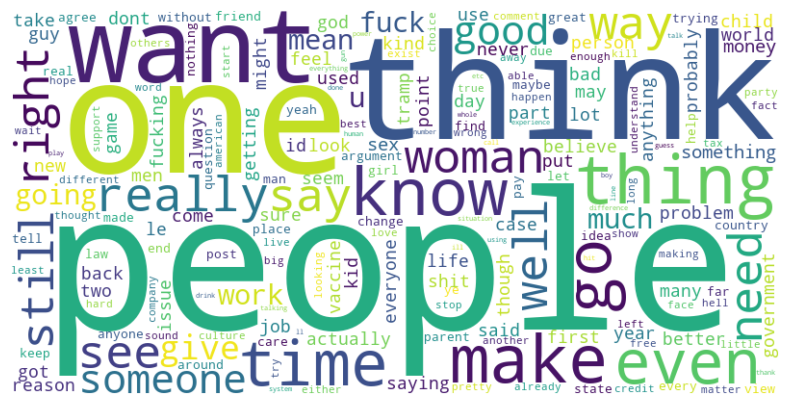

In [23]:
all_words = ' '.join([str(text) for text in df['Processed_Comment']])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

                                   Processed_Comment  score
0  difference average earnings men woman explaine... -0.083
1                 myth gap entirely based sex person -0.022
3  assertion woman get paid le job they get paid ... -0.146
4  you said op that not what they measuring they ... -0.083
5  men woman not played le job i not think many p... -0.042


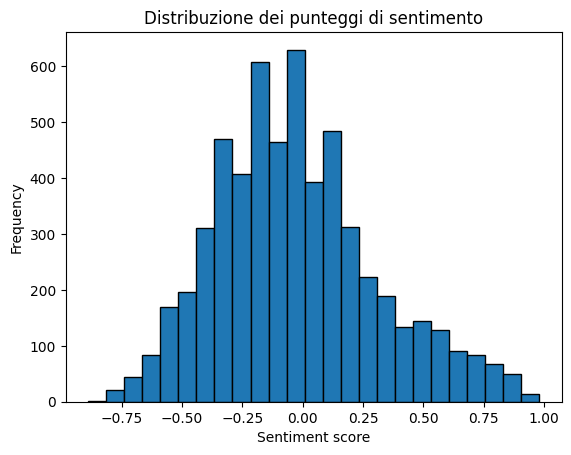

In [10]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Polarità [-1, 1]

# Applicare la funzione al dataset
df['sentiment_score'] = df['Processed_Comment'].apply(get_sentiment)

# Visualizzare i primi risultati
print(df[['Processed_Comment', 'score']].head())

# Distribuzione dei punteggi di sentimento
plt.hist(df['score'], bins=25, edgecolor='black')
plt.title('Distribuzione dei punteggi di sentimento')
plt.xlabel('Sentiment score')
plt.ylabel('Frequency')
plt.show()

In [11]:
import numpy as np

# condizioni
condizioni = [
    df['sentiment_score'] < -0.20,
    df['sentiment_score'] > 0.20
]
# etichette corrispondenti
scelte = ['negative', 'positive']

# crea la colonna: di default 'neutral'
df['Sentiment'] = np.select(condizioni, scelte, default='neutral')


In [51]:
counts = df['Sentiment'].value_counts()
print(counts)


Sentiment
neutral     3779
positive    1221
negative     722
Name: count, dtype: int64


🔹 Distribuzione delle classi nel dataset:
Sentiment
neutral     3779
positive    1221
negative     722
Name: count, dtype: int64


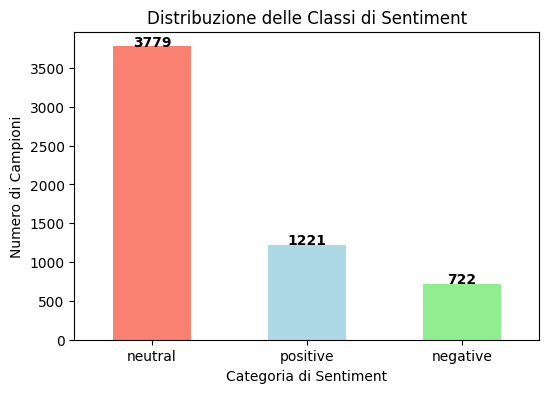

In [52]:
class_distribution = df['Sentiment'].value_counts()

class_distribution

# 📌 Stampa la distribuzione numerica
print("🔹 Distribuzione delle classi nel dataset:")
print(class_distribution)

# 📌 Visualizzazione della distribuzione con un grafico a barre
plt.figure(figsize=(6, 4))
class_distribution.plot(kind='bar', color=['salmon', 'lightblue', 'lightgreen'])
plt.title("Distribuzione delle Classi di Sentiment")
plt.xlabel("Categoria di Sentiment")
plt.ylabel("Numero di Campioni")

# 📌 Aggiungere i numeri sopra le barre
for index, value in enumerate(class_distribution):
    plt.text(index, value + 5, str(value), ha='center', fontsize=10, fontweight='bold')

plt.xticks(rotation=0)
plt.show()

TF-IDF

🔹 Distribuzione classi PRIMA del bilanciamento:
Sentiment
neutral     3779
positive    1221
negative     722
Name: count, dtype: int64

🔹 Distribuzione classi DOPO il bilanciamento:
Sentiment
negative    3700
neutral     3700
positive    3700
Name: count, dtype: int64


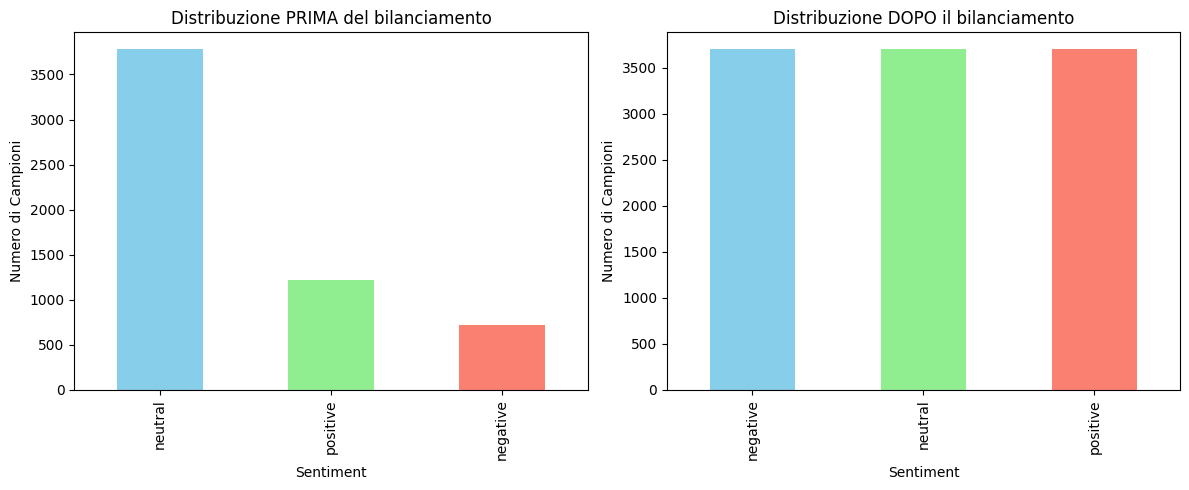


🔹 Dimensione Training Set: (8880, 15000)
🔹 Dimensione Test Set: (2220, 15000)


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,3))  # Include unigrammi, bigrammi e trigrammi
X_tfidf = tfidf.fit_transform(df['Processed_Comment'])

print("🔹 Distribuzione classi PRIMA del bilanciamento:")
print(df['Sentiment'].value_counts())

under_sampler = RandomUnderSampler(sampling_strategy={'neutral': 3700}, random_state=42)
X_under, y_under = under_sampler.fit_resample(X_tfidf, df['Sentiment'])

smote = SMOTE(sampling_strategy={'negative': 3700, 'positive': 3700}, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_under, y_under)

print("\n🔹 Distribuzione classi DOPO il bilanciamento:")
print(pd.Series(y_balanced).value_counts())

X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df['Sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'], ax=axes[0])
axes[0].set_title('Distribuzione PRIMA del bilanciamento')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Numero di Campioni')

pd.Series(y_balanced).value_counts().plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'], ax=axes[1])
axes[1].set_title('Distribuzione DOPO il bilanciamento')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Numero di Campioni')

plt.tight_layout()
plt.show()

print(f"\n🔹 Dimensione Training Set: {X_train_sent.shape}")
print(f"🔹 Dimensione Test Set: {X_test_sent.shape}")

Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV

normalizer = Normalizer()
X_train_sent = normalizer.fit_transform(X_train_sent)
X_test_sent = normalizer.transform(X_test_sent)

param_grid = {'alpha': [0.1, 0.5, 1.0, 5, 10]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train_sent, y_train_sent)

best_alpha = grid_search.best_params_['alpha']
print(f"🔹 Miglior alpha trovato: {best_alpha}")

nb_classifier = ComplementNB(alpha=best_alpha)
nb_classifier.fit(X_train_sent, y_train_sent)

y_pred_nb = nb_classifier.predict(X_test_sent)

print("🔹 Naïve Bayes Performance:")
print(classification_report(y_test_sent, y_pred_nb))



🔹 Miglior alpha trovato: 0.1
🔹 Naïve Bayes Performance:
              precision    recall  f1-score   support

    negative       0.89      0.99      0.93       740
     neutral       0.92      0.69      0.79       740
    positive       0.82      0.93      0.88       740

    accuracy                           0.87      2220
   macro avg       0.88      0.87      0.87      2220
weighted avg       0.88      0.87      0.87      2220



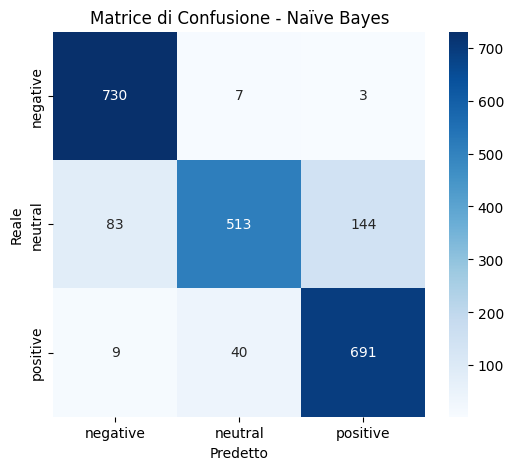

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_sent, y_pred_nb)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di Confusione - Naïve Bayes")
plt.show()

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

scaler = StandardScaler(with_mean=False) # per gestire le matrici sparse geenrate da TF-IDF
X_train_scaled = scaler.fit_transform(X_train_sent)  # Usa il dataset bilanciato
X_test_scaled = scaler.transform(X_test_sent)  # Mantiene la scala nel test set

log_reg = LogisticRegression(class_weight='balanced', max_iter=500)  # Maggiori iterazioni per stabilità
log_reg.fit(X_train_scaled, y_train_sent)

y_pred_log = log_reg.predict(X_test_scaled)

print("Logistic Regression Performance:")
print(classification_report(y_test_sent, y_pred_log))

Logistic Regression Performance:
              precision    recall  f1-score   support

    negative       0.93      1.00      0.96       740
     neutral       0.95      0.78      0.86       740
    positive       0.86      0.96      0.91       740

    accuracy                           0.91      2220
   macro avg       0.92      0.91      0.91      2220
weighted avg       0.92      0.91      0.91      2220



SVM

In [61]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


scaler = StandardScaler(with_mean=False)  # Evita problemi con matrici sparse TF-IDF
X_train_scaled = scaler.fit_transform(X_train_sent)
X_test_scaled = scaler.transform(X_test_sent)


param_grid = {
    'C': [0.1, 1, 10, 100],  # Parametro di regolarizzazione
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],  # Parametro di kernel
    'kernel': ['rbf', 'linear']  # Manteniamo il kernel RBF
}


grid_search = GridSearchCV(
    SVC(class_weight='balanced'),
    param_grid,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1)

grid_search.fit(X_train_scaled, y_train_sent)

print(f"🔹 Migliori parametri trovati: {grid_search.best_params_}")

best_svm = grid_search.best_estimator_

svm_predictions_rbf = best_svm.predict(X_test_scaled)

print("🔹 Report delle performance (SVM con GridSearch e StandardScaler):")
print(classification_report(y_test_sent, svm_predictions_rbf))

🔹 Migliori parametri trovati: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
🔹 Report delle performance (SVM con GridSearch e StandardScaler):
              precision    recall  f1-score   support

    negative       0.97      0.98      0.98       740
     neutral       0.89      0.95      0.92       740
    positive       0.98      0.90      0.94       740

    accuracy                           0.94      2220
   macro avg       0.95      0.94      0.94      2220
weighted avg       0.95      0.94      0.94      2220



Word2Vec + Padding

In [3]:
! pip install numpy pandas matplotlib wordcloud nltk scikit-learn textblob gensim imblearn demoji tensorflow keras seaborn transformers torch

  Using cached textblob-0.19.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Using cached demoji-1.1.0-py3-none-any.whl.metadata (9.2 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached rich-14.0.0-py3-n

In [13]:
import gensim.downloader as api
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

word2vec_model = api.load("word2vec-google-news-300")

def get_word2vec_sequence(comment):
    tokens = word_tokenize(comment)
    vectors = [word2vec_model[word] for word in tokens if word in word2vec_model]
    return np.array(vectors, dtype=np.float32) if vectors else np.zeros((1, 300), dtype=np.float32)

word2vec_sequences = [get_word2vec_sequence(comment) for comment in df['Processed_Comment']]

sequence_lengths = [seq.shape[0] for seq in word2vec_sequences]
optimal_length = int(np.mean(sequence_lengths) + np.std(sequence_lengths))

word2vec_sequences_padded = pad_sequences(word2vec_sequences, maxlen=optimal_length, dtype='float32', padding='post', truncating='post')

X_word2vec = np.array(word2vec_sequences_padded, dtype=np.float32)

sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['Sentiment_Numeric'] = df['Sentiment'].map(sentiment_mapping)

print("🔹 Distribuzione classi PRIMA del bilanciamento:")
print(pd.Series(df['Sentiment_Numeric']).value_counts())

X_word2vec_flat = X_word2vec.reshape(X_word2vec.shape[0], -1) 
under_sampler = RandomUnderSampler(sampling_strategy={1: 3700}, random_state=42)
X_under, y_under = under_sampler.fit_resample(X_word2vec_flat, df['Sentiment_Numeric'])

smote = SMOTE(sampling_strategy={0: 3700, 2: 3700}, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_under, y_under)

print("\n🔹 Distribuzione classi DOPO il bilanciamento:")
print(pd.Series(y_balanced).value_counts())

X_balanced = X_balanced.reshape(-1, optimal_length, 300)

X_train_sent_seq, X_test_sent_seq, y_train_sent, y_test_sent = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

print(f"Forma di X_train_sent_seq: {X_train_sent_seq.shape}")
print(f"Forma di X_test_sent_seq: {X_test_sent_seq.shape}")
print(f"Distribuzione classi train:\n{np.bincount(y_train_sent)}")
print(f"Distribuzione classi test:\n{np.bincount(y_test_sent)}")

🔹 Distribuzione classi PRIMA del bilanciamento:
Sentiment_Numeric
1    3778
2    1222
0     722
Name: count, dtype: int64


c:\Users\alep9\Anaconda3\envs\bert\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alep9\Anaconda3\envs\bert\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\alep9\Anaconda3\envs\bert\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\alep9\Anaconda3\envs\bert\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn develope


🔹 Distribuzione classi DOPO il bilanciamento:
Sentiment_Numeric
0    3700
1    3700
2    3700
Name: count, dtype: int64
Forma di X_train_sent_seq: (8880, 38, 300)
Forma di X_test_sent_seq: (2220, 38, 300)
Distribuzione classi train:
[2960 2960 2960]
Distribuzione classi test:
[740 740 740]


LSTM

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

lstm_model = Sequential([
    Masking(mask_value=0.0, input_shape=(optimal_length, 300)),  # Ignora i padding
    LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),  # 🔹 Dropout nella LSTM
    LSTM(32, dropout=0.3, recurrent_dropout=0.3),  # 🔹 Strato LSTM più piccolo
    Dropout(0.3),  # 🔹 Dropout tra le LSTM e il Dense
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # 🔹 L2 Regularization
    Dropout(0.3),  # 🔹 Dropout anche nel Fully Connected
    Dense(3, activation='softmax')  # 🔹 Output con 3 classi
])

"""lstm_model = Sequential([
    Masking(mask_value=0.0, input_shape=(optimal_length, 300)),  # Ignora i padding
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])"""

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_sent), y=y_train_sent)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = lstm_model.fit(X_train_sent_seq, y_train_sent,
                         epochs=20,  # 🔹 Aumentato per stabilità
                         batch_size=64,  # 🔹 Batch più grande per aggiornamenti più stabili
                         validation_data=(X_test_sent_seq, y_test_sent),
                         callbacks=[early_stopping])  # 🔹 Usare pesi di classe

c:\Users\alep9\Anaconda3\envs\bert\lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.4264 - loss: 1.3062 - val_accuracy: 0.6752 - val_loss: 0.9049
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6509 - loss: 0.9173 - val_accuracy: 0.7225 - val_loss: 0.7124
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7068 - loss: 0.7612 - val_accuracy: 0.7622 - val_loss: 0.6167
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7239 - loss: 0.7009 - val_accuracy: 0.7707 - val_loss: 0.5878
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7574 - loss: 0.6397 - val_accuracy: 0.7806 - val_loss: 0.5655
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7566 - loss: 0.6138 - val_accuracy: 0.7869 - val_loss: 0.5440
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7722 - loss: 0.5854 - val_accuracy: 0.8023 - val_loss: 0.5135
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7775 - loss: 0.5789 - val_acc

Grafico di Accuracy e Loss durante l’addestramento

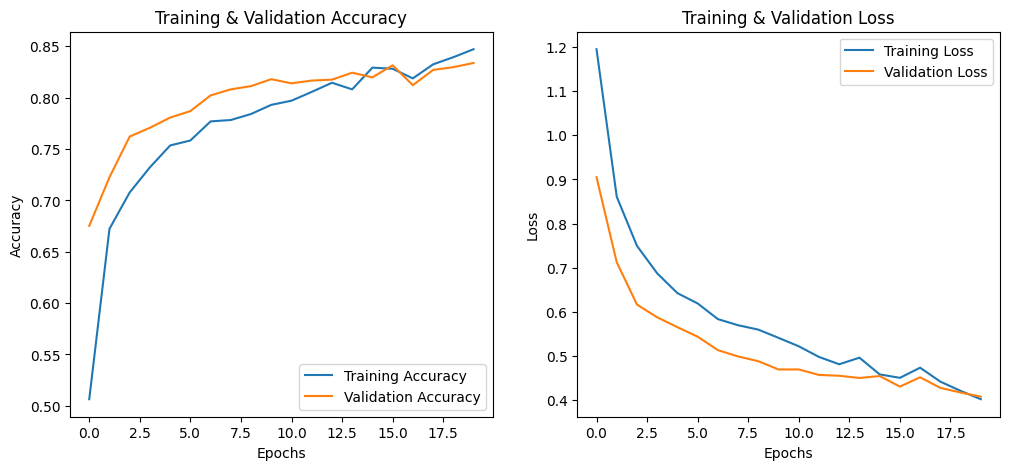

In [15]:
history = lstm_model.history.history

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
from sklearn.metrics import classification_report

y_pred_lstm = np.argmax(lstm_model.predict(X_test_sent_seq), axis=1)  # Converte probabilità in classi

report = classification_report(y_test_sent, y_pred_lstm, target_names=['negative', 'neutral', 'positive'])

print("LSTM Performance:\n", report)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
LSTM Performance:
               precision    recall  f1-score   support

    negative       0.90      0.90      0.90       740
     neutral       0.73      0.86      0.79       740
    positive       0.91      0.74      0.82       740

    accuracy                           0.83      2220
   macro avg       0.85      0.83      0.83      2220
weighted avg       0.85      0.83      0.83      2220



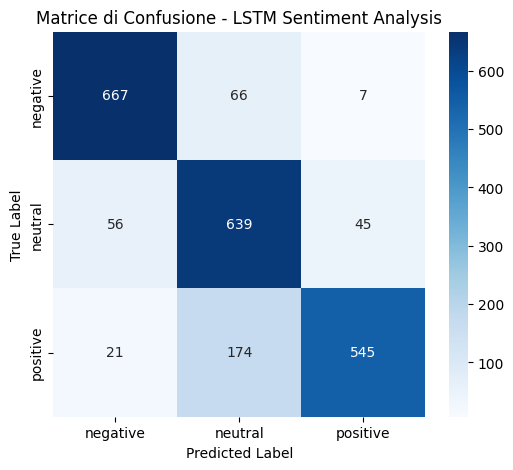

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_sent, y_pred_lstm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matrice di Confusione - LSTM Sentiment Analysis")
plt.show()

Transformer

In [18]:
import torch

# Controllare la disponibilità della GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True

Using device: cuda


In [22]:
import torch
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔹 Using device: {device}")

sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['Sentiment_Numeric'] = df['Sentiment'].map(sentiment_mapping)

print("🔹 Distribuzione classi PRIMA del bilanciamento:")
print(df['Sentiment_Numeric'].value_counts())

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Processed_Comment'].tolist(), df['Sentiment_Numeric'].tolist(),
    test_size=0.2, stratify=df['Sentiment_Numeric'], random_state=42
)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=70, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding='max_length', max_length=70, return_tensors='pt')

X_train = train_encodings['input_ids'].numpy()
y_train = np.array(train_labels)

under_sampler = RandomUnderSampler(sampling_strategy={1: 3000}, random_state=42)
X_under, y_under = under_sampler.fit_resample(X_train, y_train)

smote = SMOTE(sampling_strategy={0: 3000, 2: 3000}, random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_under, y_under)

# 📌 Stampare la distribuzione delle classi DOPO il bilanciamento
print("\n🔹 Distribuzione classi DOPO il bilanciamento:")
print(pd.Series(y_balanced).value_counts())

# 📌 **Convertire i dati bilanciati in Tensor per PyTorch**
X_balanced_tensor = torch.tensor(X_balanced, dtype=torch.long)
y_balanced_tensor = torch.tensor(y_balanced, dtype=torch.long)

# 📌 **Classe Dataset Corretto**
class SentimentDataset(Dataset):
    def __init__(self, input_ids, labels):
        self.input_ids = input_ids
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {"input_ids": self.input_ids[idx], "labels": self.labels[idx]}

# 📌 Creazione dei dataset
train_dataset = SentimentDataset(X_balanced_tensor, y_balanced_tensor)
test_dataset = SentimentDataset(test_encodings["input_ids"], torch.tensor(test_labels))

# 📌 Configura BERT con dropout più alto
config = BertConfig.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

# 📌 Caricare il modello pre-addestrato di BERT per classificazione
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
model.to(device)

# 📌 Definire l'ottimizzatore AdamW con weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=10)

# 📌 Aumentare il batch size per sfruttare la GPU
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 📌 Funzione di Training Personalizzata
def train_model(model, train_loader, val_loader, epochs=10):
    class_weights = torch.tensor([1.0 / 0.33, 1.0 / 0.33, 1.0 / 0.33]).to(device)
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    results = []
    for epoch in range(epochs):
        model.train()
        loop = tqdm(train_loader, leave=True)
        total_loss = 0
        start_time = time.time()

        for batch in loop:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)

            outputs = model(input_ids=inputs["input_ids"])
            loss = loss_fn(outputs.logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            total_loss += loss.item()
            loop.set_description(f'Epoch {epoch + 1}')
            loop.set_postfix(loss=loss.item())

        avg_training_loss = total_loss / len(train_loader)
        val_loss, val_accuracy = evaluate_model(model, val_loader)
        epoch_time = time.time() - start_time

        results.append({
            "Epoca": f"Epoca {epoch + 1}",
            "Training Loss": round(avg_training_loss, 4),
            "Validation Loss": round(val_loss, 4),
            "Validation Accuracy": round(val_accuracy, 4),
            "Training Time": time.strftime("%H:%M:%S", time.gmtime(epoch_time))
        })

    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

# 📌 Funzione di Valutazione
def evaluate_model(model, val_loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    loss_fn = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)

            outputs = model(input_ids=inputs["input_ids"])
            loss = loss_fn(outputs.logits, labels)
            total_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_loss / len(val_loader)
    accuracy = correct / total
    return avg_val_loss, accuracy

# 📌 Avviare l'addestramento
results_df = train_model(model, train_loader, val_loader, epochs=10)

# 📌 Salva il DataFrame con i risultati
results_df.to_csv("training_results.csv", index=False)

# 📌 Valutazione sul set di test
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
        labels = batch["labels"].cpu().numpy()

        outputs = model(input_ids=inputs["input_ids"])
        preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

# 📌 Salva le previsioni e i veri label
np.save("predictions.npy", np.array(all_preds))
np.save("true_labels.npy", np.array(all_labels))

🔹 Using device: cuda
🔹 Distribuzione classi PRIMA del bilanciamento:
Sentiment_Numeric
1    3778
2    1222
0     722
Name: count, dtype: int64


c:\Users\alep9\Anaconda3\envs\bert\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alep9\Anaconda3\envs\bert\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\alep9\Anaconda3\envs\bert\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\alep9\Anaconda3\envs\bert\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn develope


🔹 Distribuzione classi DOPO il bilanciamento:
0    3000
1    3000
2    3000
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 10: 100%|██████████| 282/282 [01:36<00:00,  2.93it/s, loss=0.561]


      Epoca  Training Loss  Validation Loss  Validation Accuracy Training Time
0   Epoca 1         0.9327           0.8717               0.6603      00:01:38
1   Epoca 2         0.8791           0.9108               0.5930      00:01:40
2   Epoca 3         0.8524           0.8796               0.6445      00:01:38
3   Epoca 4         0.8334           0.9204               0.6507      00:01:39
4   Epoca 5         0.8217           0.8607               0.6533      00:01:39
5   Epoca 6         0.8037           0.8520               0.6576      00:01:39
6   Epoca 7         0.7983           0.8320               0.6646      00:01:41
7   Epoca 8         0.7669           0.7913               0.6830      00:01:39
8   Epoca 9         0.7517           0.7264               0.7039      00:01:39
9  Epoca 10         0.7115           0.6809               0.7214      00:01:39


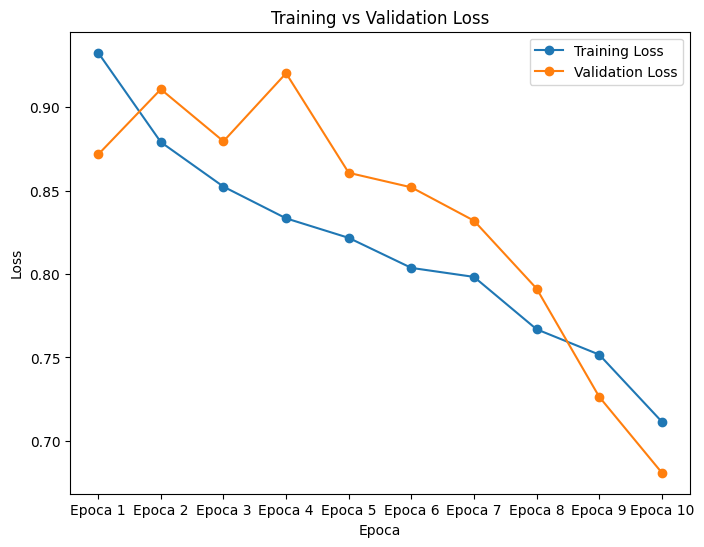

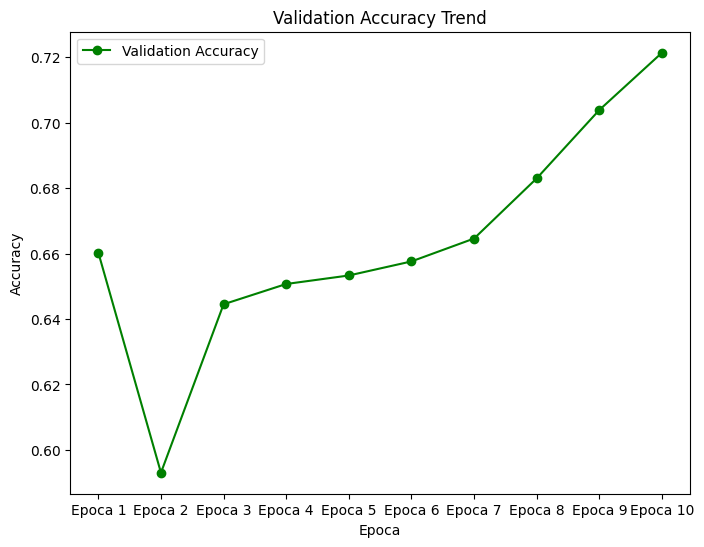

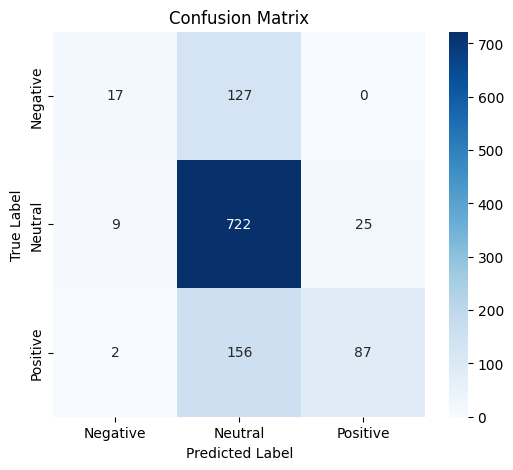


Classification Report:

              precision    recall  f1-score   support

    Negative       0.61      0.12      0.20       144
     Neutral       0.72      0.96      0.82       756
    Positive       0.78      0.36      0.49       245

    accuracy                           0.72      1145
   macro avg       0.70      0.48      0.50      1145
weighted avg       0.72      0.72      0.67      1145



In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 📌 Carica i dati salvati
results_df = pd.read_csv("training_results.csv")
all_preds = np.load("predictions.npy")
all_labels = np.load("true_labels.npy")

# 📌 Grafico Loss durante il Training
plt.figure(figsize=(8, 6))
plt.plot(results_df["Epoca"], results_df["Training Loss"], label="Training Loss", marker="o")
plt.plot(results_df["Epoca"], results_df["Validation Loss"], label="Validation Loss", marker="o")
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# 📌 Grafico Accuracy durante il Training
plt.figure(figsize=(8, 6))
plt.plot(results_df["Epoca"], results_df["Validation Accuracy"], label="Validation Accuracy", marker="o", color="green")
plt.xlabel("Epoca")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy Trend")
plt.show()

# 📌 Matrice di Confusione
cm = confusion_matrix(all_labels, all_preds)
labels = ["Negative", "Neutral", "Positive"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 📌 Report di Classificazione
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=labels))